In [ ]:
pip install sklearn matplotlib

In [ ]:
pip install transformers

In [39]:
import os
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModelForSequenceClassification.from_pretrained("bucketresearch/politicalBiasBERT")

In [40]:
# Function to get model's prediction
def get_model_prediction(text):
    tokenized_inputs = tokenizer(text, truncation=True, return_tensors='pt', max_length=512)
    inputs = {'input_ids': tokenized_inputs['input_ids'], 'attention_mask': tokenized_inputs['attention_mask']}
    outputs = model(**inputs)
    logits = outputs[0]
    probs = logits.softmax(dim=-1)[0].tolist()


    stance_mapping = {0: "left", 1: "center", 2: "right"}
    predicted_stance = stance_mapping[probs.index(max(probs))]

    return predicted_stance

In [42]:
# Load JSON files from the directory
data_dir = "./data"
all_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.json')]

true_labels = []
predicted_labels = []

for file in tqdm(all_files):
    with open(file, 'r') as f:
        article = json.load(f)

    title = article['title']
    body = " ".join([sent['sentence'] for sent in article['body']])

    # Combine title and body
    full_text = title + " " + body

    true_labels.append(article['article-level-annotations']['stance'].lower())
    predicted_labels.append(get_model_prediction(full_text))

100%|██████████| 300/300 [09:38<00:00,  1.93s/it]


In [43]:
# Total true labels

df_Labels = pd.DataFrame(true_labels)
print(df_Labels.value_counts())

center    144
left       81
right      75
dtype: int64


In [44]:
# Create a DataFrame to compare labels
df = pd.DataFrame({'True_Labels': true_labels, 'Predicted_Labels': predicted_labels})

# Evaluate the model's performance
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(true_labels, predicted_labels))

Accuracy: 0.4733
              precision    recall  f1-score   support

      center       0.50      0.69      0.58       144
        left       0.27      0.15      0.19        81
       right       0.54      0.41      0.47        75

    accuracy                           0.47       300
   macro avg       0.44      0.42      0.41       300
weighted avg       0.45      0.47      0.45       300



<Figure size 1000x700 with 0 Axes>

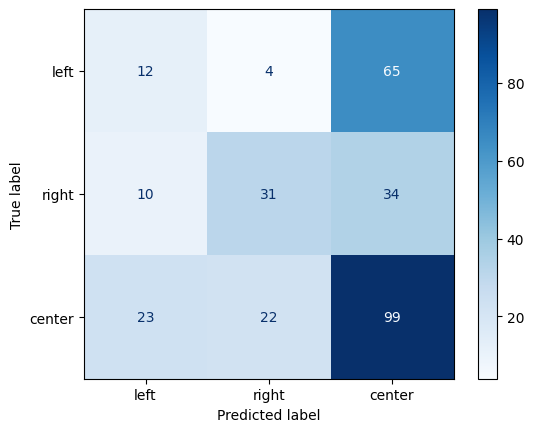

In [45]:
# Compute confusion matrix
matrix = confusion_matrix(df['True_Labels'], df['Predicted_Labels'], labels=list(set(true_labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=list(set(true_labels)))

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.show()

**Accuracy with only title**

In [46]:
# Function to get model's prediction
def get_model_prediction(text):
    inputs = tokenizer(text,  return_tensors='pt')
    probs_list = []
    outputs = model(**inputs)
    logits = outputs[0]
    probs = logits.softmax(dim=-1)[0].tolist()
    probs_list.append(probs)

    # Averaging predictions across chunks
    avg_probs = [sum(col) / len(col) for col in zip(*probs_list)]

    # Mapping highest probability to its stance
    stance_mapping = {0: "left", 1: "center", 2: "right"}
    predicted_stance = stance_mapping[avg_probs.index(max(avg_probs))]

    return predicted_stance

true_labels = []
predicted_labels = []

for file in tqdm(all_files):
    with open(file, 'r') as f:
        article = json.load(f)

    title = article['title']


    true_labels.append(article['article-level-annotations']['stance'].lower())
    predicted_labels.append(get_model_prediction(title))


# Create a DataFrame to compare labels
df = pd.DataFrame({'True_Labels': true_labels, 'Predicted_Labels': predicted_labels})

# Evaluate the model's performance
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(true_labels, predicted_labels))

100%|██████████| 300/300 [00:41<00:00,  7.19it/s]


Accuracy: 0.3400
              precision    recall  f1-score   support

      center       0.43      0.30      0.35       144
        left       0.33      0.20      0.25        81
       right       0.28      0.57      0.38        75

    accuracy                           0.34       300
   macro avg       0.35      0.36      0.33       300
weighted avg       0.37      0.34      0.33       300



<Figure size 1000x700 with 0 Axes>

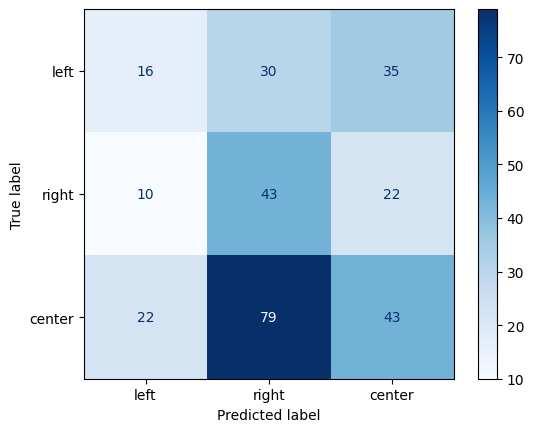

In [47]:
# Compute confusion matrix
matrix = confusion_matrix(df['True_Labels'], df['Predicted_Labels'], labels=list(set(true_labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=list(set(true_labels)))

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.show()

**Title 2**

In [48]:
def get_model_prediction(text):
    tokenized_inputs = tokenizer(text, truncation=True, return_tensors='pt', max_length=512)
    inputs = {'input_ids': tokenized_inputs['input_ids'], 'attention_mask': tokenized_inputs['attention_mask']}
    outputs = model(**inputs)
    logits = outputs[0]
    probs = logits.softmax(dim=-1)[0].tolist()

    stance_mapping = {0: "left", 1: "center", 2: "right"}
    predicted_stance = stance_mapping[probs.index(max(probs))]

    return predicted_stance, probs

In [49]:
# Initialize the DataFrame
stance_df = pd.DataFrame(columns=['Chosen Stance', 'Left Prob', 'Center Prob', 'Right Prob'])

In [50]:
predicted_labels = []
true_labels = []
for file in tqdm(all_files, position = 0):
    with open(file, 'r') as f:
        article = json.load(f)

    title = article['title']


    true_labels.append(article['article-level-annotations']['stance'].lower())

    # Get the predicted stance and probabilities
    predicted_stance, probs = get_model_prediction(title)
    predicted_labels.append(predicted_stance)


    new_row_df = pd.DataFrame([{
        'File': file,
        'Chosen Stance': predicted_stance,
        'Left Prob': probs[0],
        'Center Prob': probs[1],
        'Right Prob': probs[2]
    }])
    stance_df = pd.concat([stance_df,new_row_df], ignore_index=True)


100%|██████████| 300/300 [00:42<00:00,  7.13it/s]


In [51]:
len(predicted_labels)

300

In [52]:
len(true_labels)

300

In [53]:
# Create a DataFrame to compare labels
df = pd.DataFrame({'True_Labels': true_labels, 'Predicted_Labels': predicted_labels})

# Evaluate the model's performance
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(true_labels, predicted_labels))

Accuracy: 0.3400
              precision    recall  f1-score   support

      center       0.43      0.30      0.35       144
        left       0.33      0.20      0.25        81
       right       0.28      0.57      0.38        75

    accuracy                           0.34       300
   macro avg       0.35      0.36      0.33       300
weighted avg       0.37      0.34      0.33       300



In [54]:
stance_df

,Chosen Stance,Left Prob,Center Prob,Right Prob,File
0,right,0.101065,0.184450,0.714485,./data/48_fox.json
1,right,0.116997,0.431707,0.451296,./data/74_fox.json
2,right,0.370063,0.197329,0.432608,./data/28_nyt.json
3,center,0.265897,0.556001,0.178102,./data/66_hpo.json
4,right,0.281022,0.205492,0.513486,./data/45_hpo.json
...,...,...,...,...,...
295,center,0.296741,0.568830,0.134429,./data/54_nyt.json
296,center,0.016453,0.961793,0.021755,./data/79_hpo.json
297,right,0.230254,0.103519,0.666228,./data/72_nyt.json
298,right,0.325423,0.137562,0.537015,./data/18_fox.json


In [55]:
# Compute average of 'Left Prob' when the chosen stance is 'left'
left_avg_prob = stance_df[stance_df['Chosen Stance'] == 'left']['Left Prob'].mean()

# Compute average of 'Center Prob' when the chosen stance is 'center'
center_avg_prob = stance_df[stance_df['Chosen Stance'] == 'center']['Center Prob'].mean()

# Compute average of 'Right Prob' when the chosen stance is 'right'
right_avg_prob = stance_df[stance_df['Chosen Stance'] == 'right']['Right Prob'].mean()

print("Average 'Left Prob' when chosen: ", left_avg_prob)
print("Average 'Center Prob' when chosen: ", center_avg_prob)
print("Average 'Right Prob' when chosen: ", right_avg_prob)

Average 'Left Prob' when chosen:  0.5464358994116386
Average 'Center Prob' when chosen:  0.7951970645785331
Average 'Right Prob' when chosen:  0.5958106188397658


**Adding a confidence threshold**

In [56]:
def get_model_prediction(text, confidence_threshold=0.9):
    tokenized_inputs = tokenizer(text, truncation=True, return_tensors='pt', max_length=512)
    inputs = {'input_ids': tokenized_inputs['input_ids'], 'attention_mask': tokenized_inputs['attention_mask']}
    outputs = model(**inputs)
    logits = outputs[0]
    probs = logits.softmax(dim=-1)[0].tolist()
    stance_mapping = {0: "left", 1: "center", 2: "right"}
    max_prob = max(probs)
    print(probs)

    if max_prob < 0.9:
        return "uncertain"
    else:
        predicted_stance = stance_mapping[probs.index(max_prob)]
        return predicted_stance

In [ ]:
# Load JSON files from the directory
data_dir = "./data"
all_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.json')]

true_labels = []
predicted_labels = []

for file in tqdm(all_files):
    with open(file, 'r') as f:
        article = json.load(f)

    title = article['title']
    body = " ".join([sent['sentence'] for sent in article['body']])
    full_text = title + " " + body

    true_label = article['article-level-annotations']['stance'].lower()
    predicted_label = get_model_prediction(full_text)


    true_labels.append(true_label)
    predicted_labels.append(predicted_label)


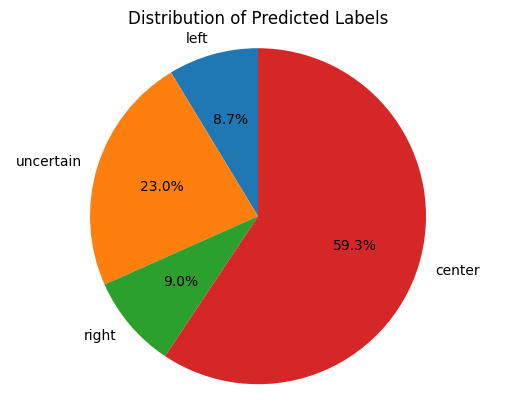

In [58]:
# Create a pie chart for predicted labels
label_counts = {label: predicted_labels.count(label) for label in set(predicted_labels)}
labels = label_counts.keys()
sizes = label_counts.values()

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Distribution of Predicted Labels")
plt.show()

In [59]:
# Filter out 'uncertain' predictions
filtered_true_labels = []
filtered_predicted_labels = []

for true_label, predicted_label in zip(true_labels, predicted_labels):
    if predicted_label != "uncertain":
        filtered_true_labels.append(true_label)
        filtered_predicted_labels.append(predicted_label)

Accuracy: 0.4848
              precision    recall  f1-score   support

      center       0.49      0.80      0.61       109
        left       0.27      0.10      0.15        70
       right       0.67      0.35      0.46        52

    accuracy                           0.48       231
   macro avg       0.47      0.41      0.40       231
weighted avg       0.46      0.48      0.43       231



<Figure size 1000x700 with 0 Axes>

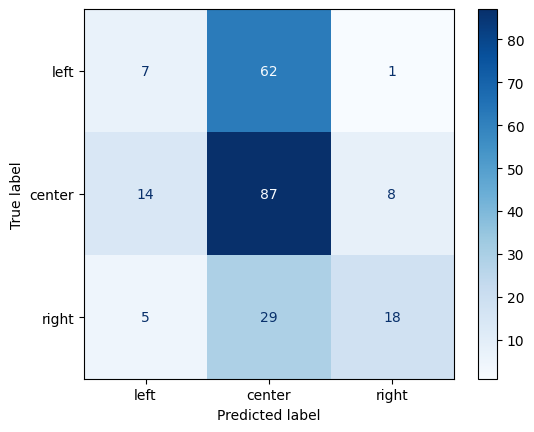

In [60]:
# Evaluate the model's performance
accuracy = accuracy_score(filtered_true_labels, filtered_predicted_labels)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(filtered_true_labels, filtered_predicted_labels))

# Compute confusion matrix
matrix = confusion_matrix(filtered_true_labels, filtered_predicted_labels, labels=["left", "center", "right"])
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["left", "center", "right"])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.show()

**confidence threshold only title**

In [ ]:
def get_model_prediction(text, confidence_threshold=0.5):
    tokenized_inputs = tokenizer(text, truncation=True, return_tensors='pt', max_length=512)
    inputs = {'input_ids': tokenized_inputs['input_ids'], 'attention_mask': tokenized_inputs['attention_mask']}
    outputs = model(**inputs)
    logits = outputs[0]
    probs = logits.softmax(dim=-1)[0].tolist()
    stance_mapping = {0: "left", 1: "center", 2: "right"}
    max_prob = max(probs)
    print(probs)

    if max_prob < 0.5:
        return "uncertain"
    else:
        predicted_stance = stance_mapping[probs.index(max_prob)]
        return predicted_stance

true_labels = []
predicted_labels = []

for file in tqdm(all_files):
    with open(file, 'r') as f:
        article = json.load(f)

    title = article['title']


    true_labels.append(article['article-level-annotations']['stance'].lower())
    predicted_labels.append(get_model_prediction(title))

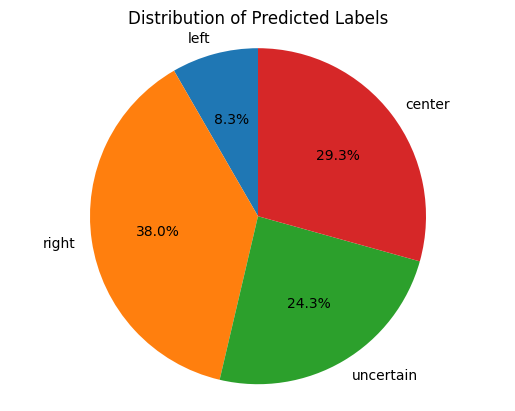

In [62]:
# Create a pie chart for predicted labels
label_counts = {label: predicted_labels.count(label) for label in set(predicted_labels)}
labels = label_counts.keys()
sizes = label_counts.values()

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Distribution of Predicted Labels")
plt.show()

In [63]:
# Filter out 'uncertain' predictions
filtered_true_labels = []
filtered_predicted_labels = []

for true_label, predicted_label in zip(true_labels, predicted_labels):
    if predicted_label != "uncertain":
        filtered_true_labels.append(true_label)
        filtered_predicted_labels.append(predicted_label)

Accuracy: 0.3480
              precision    recall  f1-score   support

      center       0.43      0.36      0.39       106
        left       0.32      0.12      0.18        64
       right       0.29      0.58      0.39        57

    accuracy                           0.35       227
   macro avg       0.35      0.35      0.32       227
weighted avg       0.36      0.35      0.33       227



<Figure size 1000x700 with 0 Axes>

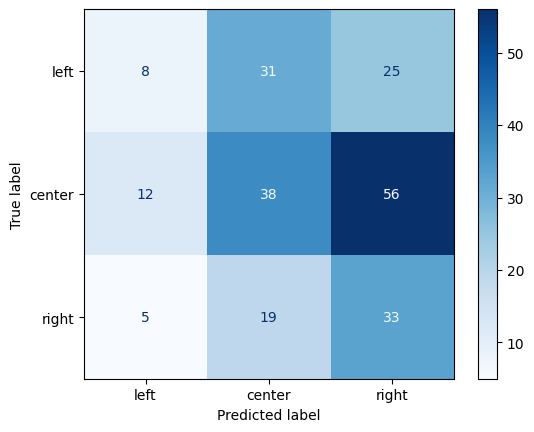

In [64]:
# Evaluate the model's performance
accuracy = accuracy_score(filtered_true_labels, filtered_predicted_labels)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(filtered_true_labels, filtered_predicted_labels))

# Compute confusion matrix
matrix = confusion_matrix(filtered_true_labels, filtered_predicted_labels, labels=["left", "center", "right"])
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["left", "center", "right"])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.show()

**K-fold**

In [ ]:
pip install torch

In [66]:
import torch
from sklearn.model_selection import KFold

In [ ]:
# Load data
data_dir = "./data"
all_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.json')]

# Prepare the data
data = []
for file in all_files:
    with open(file, 'r') as f:
        article = json.load(f)
    title = article['title']
    body = " ".join([sent['sentence'] for sent in article['body']])
    full_text = title + " " + body
    label = article['article-level-annotations']['stance'].lower()
    data.append((full_text, label))

# Convert to DataFrame
df = pd.DataFrame(data, columns=['text', 'label'])

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []

for train_index, test_index in tqdm(kf.split(df)):
    # Split data
    train_data, test_data = df.iloc[train_index], df.iloc[test_index]

    # Get predictions for each test split
    predicted_labels = [get_model_prediction(text) for text in test_data['text']]
    true_labels = test_data['label'].tolist()

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    accuracy_scores.append(accuracy)

# Average accuracy across all folds
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Average Accuracy: {average_accuracy:.4f}")

In [68]:
print(accuracy_scores)

[0.43333333333333335, 0.4666666666666667, 0.4166666666666667, 0.55, 0.4666666666666667]


**Different token lengths**

Processing with max_length = 128


100%|██████████| 300/300 [03:05<00:00,  1.62it/s]

Accuracy for max_length 128: 0.4633
              precision    recall  f1-score   support

      center       0.50      0.72      0.59       144
        left       0.20      0.11      0.14        81
       right       0.55      0.36      0.44        75

    accuracy                           0.46       300
   macro avg       0.42      0.40      0.39       300
weighted avg       0.43      0.46      0.43       300



<Figure size 1000x700 with 0 Axes>

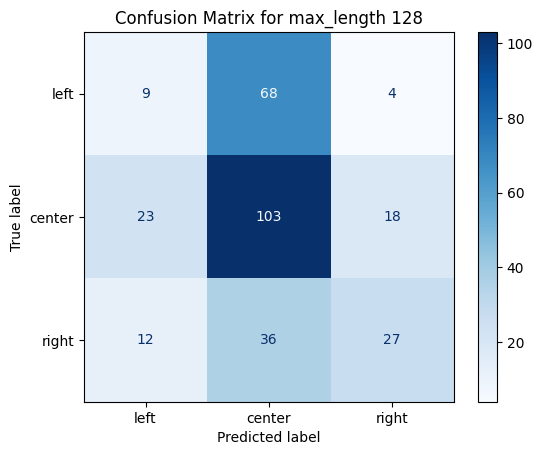

Processing with max_length = 256


100%|██████████| 300/300 [05:08<00:00,  1.03s/it]

Accuracy for max_length 256: 0.4667
              precision    recall  f1-score   support

      center       0.50      0.69      0.58       144
        left       0.23      0.14      0.17        81
       right       0.57      0.39      0.46        75

    accuracy                           0.47       300
   macro avg       0.43      0.41      0.40       300
weighted avg       0.44      0.47      0.44       300



<Figure size 1000x700 with 0 Axes>

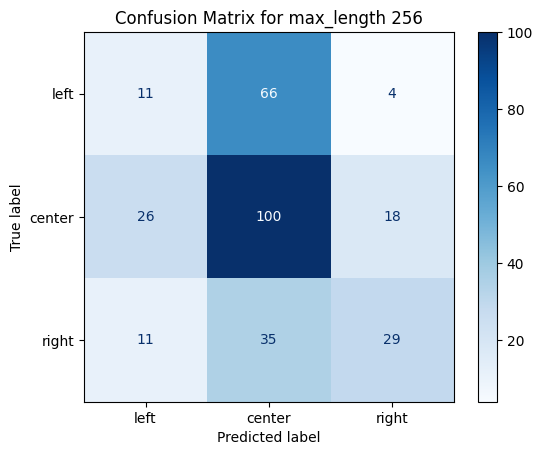

Processing with max_length = 512


100%|██████████| 300/300 [09:07<00:00,  1.83s/it]

Accuracy for max_length 512: 0.4733
              precision    recall  f1-score   support

      center       0.50      0.69      0.58       144
        left       0.27      0.15      0.19        81
       right       0.54      0.41      0.47        75

    accuracy                           0.47       300
   macro avg       0.44      0.42      0.41       300
weighted avg       0.45      0.47      0.45       300



<Figure size 1000x700 with 0 Axes>

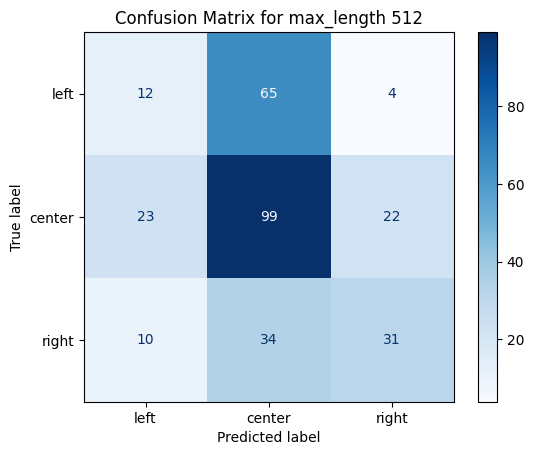

Processing with max_length = 1024


100%|██████████| 300/300 [19:34<00:00,  3.92s/it]

Accuracy for max_length 1024: 0.2867
              precision    recall  f1-score   support

      center       0.71      0.03      0.07       144
        left       0.29      0.22      0.25        81
       right       0.27      0.84      0.41        75

    accuracy                           0.29       300
   macro avg       0.42      0.37      0.24       300
weighted avg       0.49      0.29      0.20       300



<Figure size 1000x700 with 0 Axes>

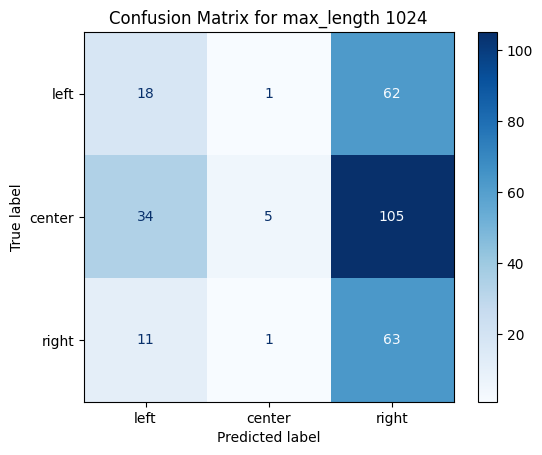

Processing with max_length = 2048


100%|██████████| 300/300 [19:21<00:00,  3.87s/it]

Accuracy for max_length 2048: 0.2867
              precision    recall  f1-score   support

      center       0.71      0.03      0.07       144
        left       0.29      0.22      0.25        81
       right       0.27      0.84      0.41        75

    accuracy                           0.29       300
   macro avg       0.42      0.37      0.24       300
weighted avg       0.49      0.29      0.20       300



<Figure size 1000x700 with 0 Axes>

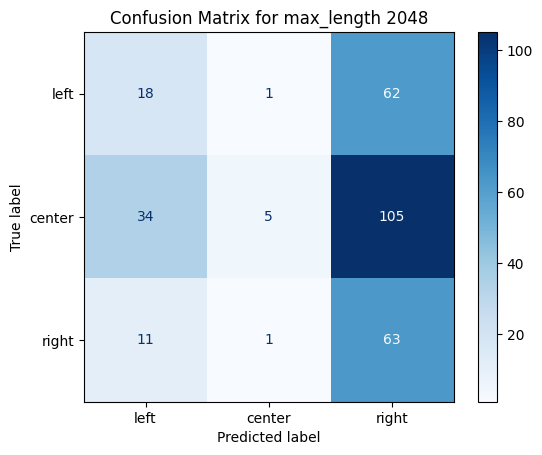

In [69]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

stance_mapping = {0: "left", 1: "center", 2: "right"}

# Modified function to handle different max lengths and chunking
def get_model_prediction(text, max_length):
    # Chunking if length is greater than 512
    if max_length > 512:
        chunks = [text[i:i + 512] for i in range(0, len(text), 512)]
        avg_probs = np.zeros(3)
        for chunk in chunks:
            tokenized_inputs = tokenizer(chunk, truncation=True, return_tensors='pt', max_length=512)
            inputs = {'input_ids': tokenized_inputs['input_ids'], 'attention_mask': tokenized_inputs['attention_mask']}
            outputs = model(**inputs)
            logits = outputs[0]
            probs = logits.softmax(dim=-1)[0].tolist()
            avg_probs += np.array(probs)
        avg_probs /= len(chunks)
    else:
        tokenized_inputs = tokenizer(text, truncation=True, return_tensors='pt', max_length=max_length)
        inputs = {'input_ids': tokenized_inputs['input_ids'], 'attention_mask': tokenized_inputs['attention_mask']}
        outputs = model(**inputs)
        logits = outputs[0]
        avg_probs = logits.softmax(dim=-1)[0].tolist()

    stance_mapping = {0: "left", 1: "center", 2: "right"}
    predicted_stance = stance_mapping[np.argmax(avg_probs)]

    return predicted_stance

# Load JSON files
data_dir = "./data"
all_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.json')]

# Iterate over different max lengths
for max_length in [128, 256, 512, 1024, 2048]:
    print(f"Processing with max_length = {max_length}")
    true_labels = []
    predicted_labels = []

    for file in tqdm(all_files):
        with open(file, 'r') as f:
            article = json.load(f)

        title = article['title']
        body = " ".join([sent['sentence'] for sent in article['body']])
        full_text = title + " " + body

        true_labels.append(article['article-level-annotations']['stance'].lower())
        predicted_labels.append(get_model_prediction(full_text, max_length))

    # Create DataFrame and evaluate
    df = pd.DataFrame({'True_Labels': true_labels, 'Predicted_Labels': predicted_labels})
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"Accuracy for max_length {max_length}: {accuracy:.4f}")
    print(classification_report(true_labels, predicted_labels))

    # Compute confusion matrix
    # Ensure the labels are in the correct order: ['left', 'center', 'right']
    ordered_labels = ['left', 'center', 'right']
    matrix = confusion_matrix(df['True_Labels'], df['Predicted_Labels'], labels=ordered_labels)

    # Pass the ordered labels to the display
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=ordered_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for max_length {max_length}")
    plt.show()